# Praktiskais darbs 2. Stereo attēlu dispritātes kartes un dziļuma kartes iegūšana
RTU DE0942 • Datorredze

**Mērķis:** Apgūt dziļuma informācijas ieguvi no stereo pāriem, izmantojot disparitātes aprēķinu un kameras kalibrācijas parametrus.
**Uzdevumi:**
1. Disparitātes karte bez kalibrācijas (Middlebury dati)
2. Disparitāte un dziļuma karte ar kalibrācijas datiem
3. Disparitātes un dziļuma karte ar reāliem attēliem



## prepare data

In [17]:
from google.colab import files
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import re

In [18]:
!pip install gdown -q

In [36]:
import gdown
import os
import json

shared_link = 'https://drive.google.com/drive/folders/1K7-eACktkQLzM3gHhgXZLXu-nUro8w6Y?usp=sharing'

folder_path_root = 'middlebury_data'
if os.path.exists(folder_path_root) is False:
  # Extract the folder ID from the shared link
  folder_id = shared_link.split('/')[-1]

  # Define the output directory
  output_dir = 'middlebury_data'

  # Create the output directory if it doesn't exist
  os.makedirs(output_dir, exist_ok=True)

  # Download the folder using gdown
  gdown.download_folder(id=folder_id, output=output_dir, quiet=True, use_cookies=False)

print(f"Folder downloaded to: {output_dir}")
!ls $folder_path_root
!ls -lah $folder_path_root/imperfect

Folder downloaded to: middlebury_data
imperfect  mine  perfect
total 14M
drwxr-xr-x 2 root root 4.0K Oct 22 21:24 .
drwxr-xr-x 5 root root 4.0K Oct 22 21:24 ..
-rw-r--r-- 1 root root  223 Oct 18 09:11 calib.txt
-rw-r--r-- 1 root root 6.8M Oct 18 09:12 im0.png
-rw-r--r-- 1 root root 6.7M Oct 18 09:12 im1.png


In [20]:
img_imperfect_path = [
    f"{folder_path_root}/imperfect/im0.png",
    f"{folder_path_root}/imperfect/im1.png",
    f"{folder_path_root}/imperfect/calib.txt",
]

img_perfect_path = [
    f"{folder_path_root}/perfect/im0.png",
    f"{folder_path_root}/perfect/im1.png",
    f"{folder_path_root}/imperfect/calib.txt",
]

img_mine_path01 = [
    f"{folder_path_root}/mine/01left.jpg",
    f"{folder_path_root}/mine/01right.jpg",
    f"{folder_path_root}/mine/01calib.json",
]
img_mine_path02 = [
    f"{folder_path_root}/mine/02left.jpg",
    f"{folder_path_root}/mine/02right.jpg",
    f"{folder_path_root}/mine/02calib.json",
]
img_mine_path03 = [
    f"{folder_path_root}/mine/03left.jpg",
    f"{folder_path_root}/mine/03right.jpg",
    f"{folder_path_root}/mine/03calib.json",
]

In [21]:

def isGrayscale(img):
  return len(img.shape) == 2 or (len(img.shape) == 3 and img.shape[2] == 1)

def plotImage(img, title , cmap = None, colorbar_title = None):
  plt.figure(figsize=(10, 4))

  if cmap is None:
    if isGrayscale(img):
      plt.imshow(img, cmap='gray') # useful for grayscale images to avoid false coloring
    else:
      plt.imshow(img)
  else:
    plt.imshow(img, cmap=cmap)

  if colorbar_title:
    plt.colorbar(label=colorbar_title)

  plt.title(title)
  plt.axis('off')
  plt.show()

def plotImgSideBySide(img1, title1, img2, title2, subtitle=None, cmap1 = None, cmap2=None, img2_vmax=None, colorbar1_title = None, colorbar2_title = None):
  fig, axs = plt.subplots(1, 2, figsize=(16, 6))

  if cmap1 is None:
    if isGrayscale(img1):
      axs[0].imshow(img1, cmap='gray') # useful for grayscale images to avoid false coloring
    else:
      axs[0].imshow(img1)
  else:
    axs[0].imshow(img1, cmap=cmap1)

  if colorbar1_title:
    fig.colorbar(axs[0].images[0], ax=axs[0], label=colorbar1_title)
  axs[0].set_title(title1)
  axs[0].axis('off')


  if cmap2 is None:
    if isGrayscale(img2):
      axs[1].imshow(img2, cmap='gray', vmax=img2_vmax) # useful for grayscale images to avoid false coloring
    else:
      axs[1].imshow(img2, vmax=img2_vmax)
  else:
    axs[1].imshow(img2, cmap=cmap2, vmax=img2_vmax)

  if colorbar2_title:
    fig.colorbar(axs[1].images[0], ax=axs[1], label=colorbar2_title)
  axs[1].set_title(title2)
  axs[1].axis('off')

  if subtitle is not None:
    fig.suptitle(subtitle, fontsize=16)
  plt.show()

def plotImgSideBySideTriple(img1, title1, img2, title2, img3, title3):
  plt.figure(figsize=(15, 5))

  plt.subplot(1, 3, 1)
  plt.title(title1)
  if isGrayscale(img1):
    plt.imshow(img1, cmap='gray') # useful for grayscale images to avoid false coloring
  else:
    plt.imshow(img1)
  plt.axis('off')

  plt.subplot(1, 3, 2)
  plt.title(title2)
  if isGrayscale(img2):
    plt.imshow(img2, cmap='gray') # useful for grayscale images to avoid false coloring
  else:
    plt.imshow(img2)
  plt.axis('off')

  plt.subplot(1, 3, 3)
  plt.title(title3)
  if isGrayscale(img3):
    plt.imshow(img3, cmap='gray') # useful for grayscale images to avoid false coloring
  else:
    plt.imshow(img3)
  plt.axis('off')

  plt.show()


In [56]:
class Pair:
  def __init__(self, paths, mode = cv.IMREAD_GRAYSCALE, withCalib=False): # TODO why grayscale?
    self.left = None
    self.right = None

    self.calib_f_px = None
    self.calib_baseline = None
    self.calib_doffs = None

    self.isGray = mode == cv.IMREAD_GRAYSCALE

    self.load(paths, mode, withCalib)

  def load(self, paths, mode, withCalib=False):
    self.left  = cv.imread(paths[0], mode)
    self.right = cv.imread(paths[1], mode)

    assert self.left is not None and self.right is not None, "Neizdevās ielādēt attēlus! Pārbaudi failu nosaukumus."

    if withCalib:
      self.loadCalibration(paths[2])

  def loadCalibration(self, path):
    # check file is available
    if not os.path.isfile(path):
      print(f"Calibration file not found: {path}")
      return


    if path.endswith('.txt'):
        with open(path, 'r') as f:
            calib_text = f.read()

        #Parse calibration file
        # Improved regex for fx (first number after cam0=[)
        fx_match = re.search(r"cam0=\[\s*([0-9.eE+-]+)", calib_text)
        assert fx_match, f"Could not parse focal length f from {path}"
        self.calib_f_px = float(fx_match.group(1))

        # Baseline
        base_match = re.search(r"baseline\s*=\s*([0-9.eE+-]+)", calib_text)
        assert base_match, "Could not parse baseline from {path}"
        self.calib_baseline = float(base_match.group(1))

        # doffs
        doffs_match = re.search(r"doffs\s*=\s*([0-9.eE+-]+)", calib_text)
        self.calib_doffs = float(doffs_match.group(1)) if doffs_match else 0.0

    elif path.endswith('.json'):
      with open(path, 'r') as f:
        calib_json = json.load(f)

        try:
          # Use "camera_matrix" if available, fallback to "cam0"
          matrix = calib_json.get("camera_matrix") or calib_json["cam0"]
          self.calib_f_px = float(matrix[0][0])


          self.calib_baseline = float(calib_json["baseline"])
          self.calib_doffs = float(calib_json.get("doffs", 0.0))
        except KeyError as e:
            raise ValueError(f"Missing expected calibration field in JSON: {e}")


  def show(self, title = None):
    plotImgSideBySide(self.left, "Left", self.right, "Right", title)

  def toString(self):
    print(f"Left image shape: {self.left.shape}")
    print(f"Right image shape: {self.right.shape}")

    if self.calib_f_px is not None:
      print(f"Calibration -> f = {self.calib_f_px:.3f} px, baseline = {self.calib_baseline:.3f}, doffs = {self.calib_doffs:.3f}")

  @staticmethod
  def info(img):
    print(f"Custom Image shape: {img.shape}")

  def left2Grayscale(self):
    return cv.cvtColor(self.left, cv.COLOR_BGR2GRAY)

  def right2Grayscale(self):
    return cv.cvtColor(self.right, cv.COLOR_BGR2GRAY)

  """
    • Disparitātes karte — attēls, kur katra    pikseļa vērtība = 𝑑
    • Gaišāki toņi → liela disparitāte → tuvāk
    • Tumšāki toņi → mazāka disparitāte →    tālāk
    • 0 vērtība → nav atbilstības (piemēram,    fons vai ēnas)
    • Disparitātes karti aprēķina ar stereo    algoritmiem:
      •cv.StereoBM_create()
      •cv.StereoSGBM_create()
  """
  def computeDisparity(self, numDisparities = 16 * 16, blockSize = 7, color2Gray=False): #TODO why 16*6 without and 16*16 with? typo?
    #numDisparities = 16 * 6  # jābūt 16 reizinājumam
    #blockSize = 7            # nepāra

    """
      StereoSGBM (Semi-Global Block Matching) ir stereo   atbilstības algoritms, kas aprēķina disparitātes karti
      starp diviem attēliem (kreisais un labais).
      Tas meklē pikseļu atbilstības un minimizē kopējo   izmaksu funkciju, ņemot vērā:
      • līdzību starp pikseļiem,
      • un gluduma ierobežojumus starp kaimiņiem.
      Rezultāts: disparitātes karte, kur katram pikselim zināma horizontālā nobīde.
    """
    stereo = cv.StereoSGBM_create(
        minDisparity=0,
        numDisparities=numDisparities,  # diapazons, kurā meklēt atbilstības
        blockSize=blockSize,            #loga izmērs (mazāks – vairāk detaļu, bet trokšņi)
        P1=8*3*blockSize**2,            # sodi par disparitātes izmaiņām (gludums)
        P2=32*3*blockSize**2,           # sodi par disparitātes izmaiņām (gludums)
        disp12MaxDiff=1,                # TODO why it wasnt used for uncalibrated?
        uniquenessRatio=10,             # cik unikālam jābūt minimumam
        speckleWindowSize=50,           #test 100  #trokšņu grupas, kas jānoņem
        speckleRange=2 #test 32
    )

    if color2Gray and not self.isGray:
      disp = stereo.compute(self.left2Grayscale(), self.right2Grayscale()).astype(np.float32) / 16.0
    else:
      disp = stereo.compute(self.left, self.right).astype(np.float32) / 16.0

    depth = None
    if self.calib_f_px is not None:
      # 5) Compute depth (meters)
      # Middlebury baseline units = mm -> convert to meters if baseline > 10
      baseline_m = self.calib_baseline / 1000.0 if self.calib_baseline > 10 else self.calib_baseline
      disp_eff = disp + self.calib_doffs  # include disparity offset

      disp_eff[disp_eff <= 0.0] = np.nan
      depth = (self.calib_f_px * baseline_m) / disp_eff

    return disp, depth

  def showDisparityAndDepth(self, title = None):
    disp, depth = self.computeDisparity()
    plotImgSideBySide(disp, "Disparity", depth, "Depth", title, cmap1='inferno', cmap2='plasma', img2_vmax=np.nanpercentile(depth, 95), colorbar1_title='Disparity (px)', colorbar2_title='Depth (m)')

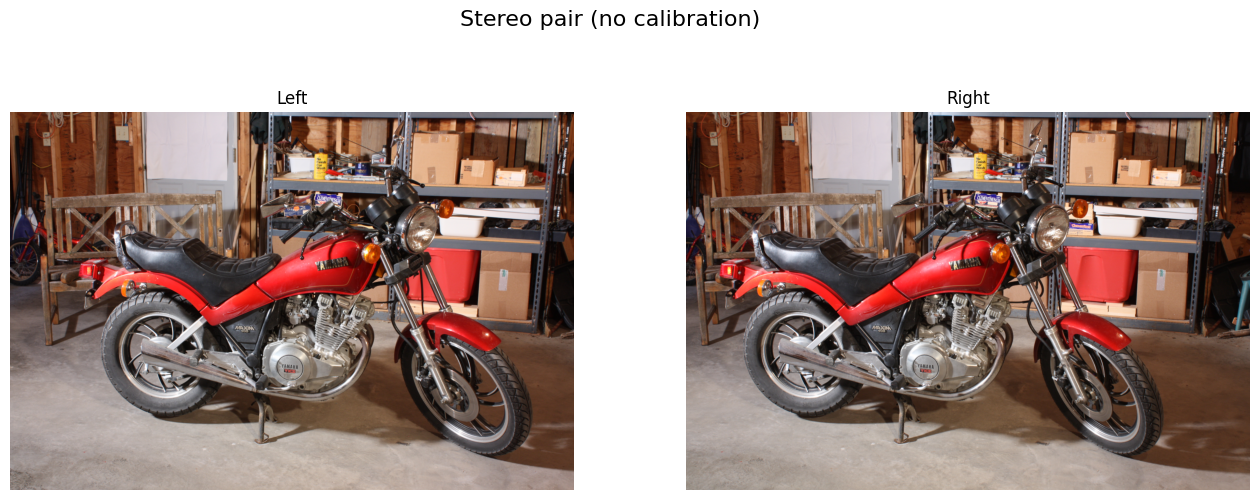

Left image shape: (1988, 2964, 3)
Right image shape: (1988, 2964, 3)
Custom Image shape: (1988, 2964)
Custom Image shape: (1988, 2964)


In [23]:
pair_imp = Pair(img_imperfect_path, cv.IMREAD_COLOR_RGB)
pair_imp.show('Stereo pair (no calibration)')
pair_imp.toString()
Pair.info(pair_imp.left2Grayscale())
Pair.info(pair_imp.right2Grayscale())

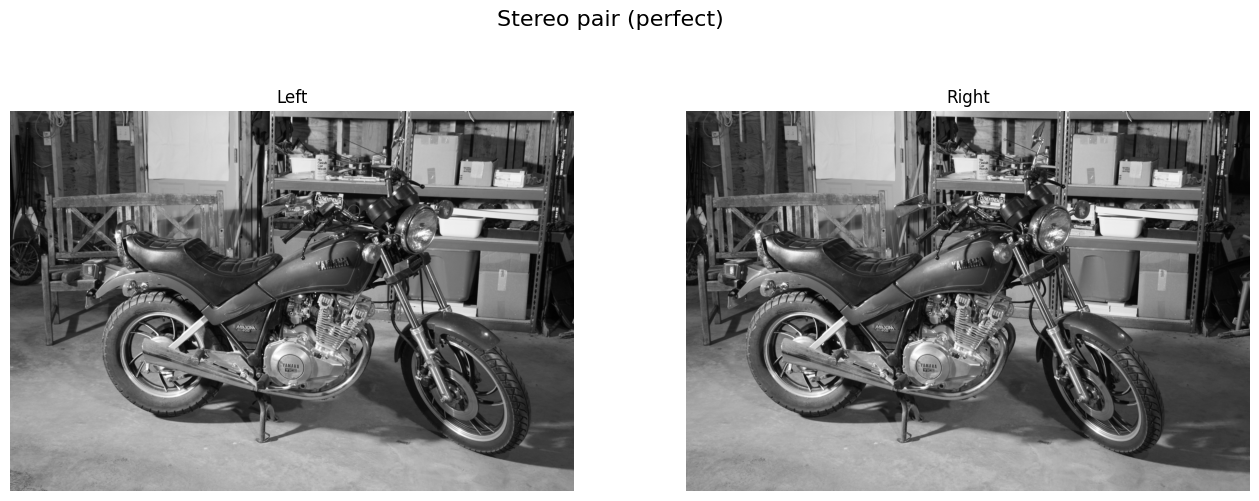

Left image shape: (2000, 2964)
Right image shape: (2000, 2964)
Calibration -> f = 3997.684 px, baseline = 193.001, doffs = 131.111


In [24]:
pair_p = Pair(img_perfect_path, withCalib=True)
pair_p.show('Stereo pair (perfect)')
pair_p.toString()

# Task


### 1. Disparitātes karte bez kalibrācijas (Middlebury dati)
* Lejupielādēt stereo attēlu pāri no Middlebury Stereo Dataset. Piemēram: Cones, Teddy, Playroom u.c.
* Augšupielādēt attēlu pāri Colab vidē (im0.png un im1.png).
* Izveidot disparitātes karti, izmantojot cv.StereoSGBM_create().
* Vizualizēt rezultātu

* Izveidot disparitātes karti, izmantojot cv.StereoSGBM_create().
* Vizualizēt rezultātu

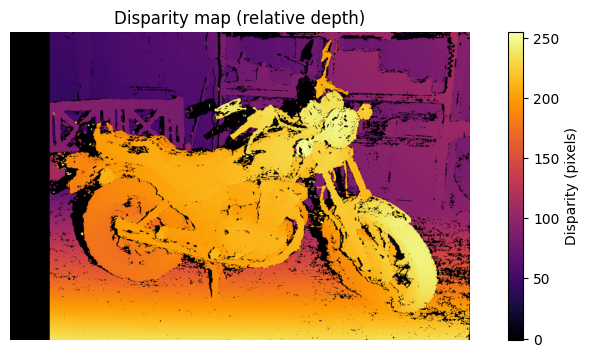

In [25]:
disp_g, _ = pair_imp.computeDisparity()
plotImage(disp_g, "Disparity map (relative depth)", 'inferno', colorbar_title='Disparity (pixels)')

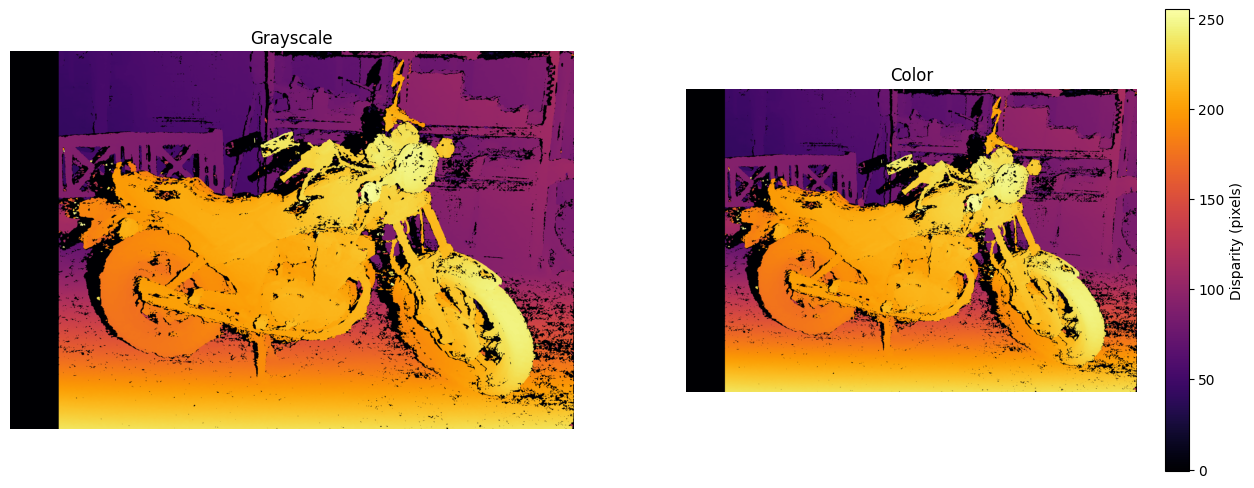

In [26]:
disp_c, _ = pair_imp.computeDisparity(color2Gray=False)
plotImgSideBySide(disp_g, "Grayscale", disp_c, "Color", cmap1='inferno', cmap2='inferno', colorbar2_title='Disparity (pixels)')

### 2. Disparitāte un dziļuma karte ar kalibrācijas datiem
* Lejupielādēt un augšupielādēt ne tikai attēlus, bet arī kalibrācijas failu no tās pašas Middlebury mapes (calib.txt).
* Nolasīt fokusa garumu 𝑓un bāzes attālumu 𝐵.


In [27]:
pair_imp.loadCalibration(img_imperfect_path[2])
pair_imp.toString()


Left image shape: (1988, 2964, 3)
Right image shape: (1988, 2964, 3)
Calibration -> f = 3997.684 px, baseline = 193.001, doffs = 131.111


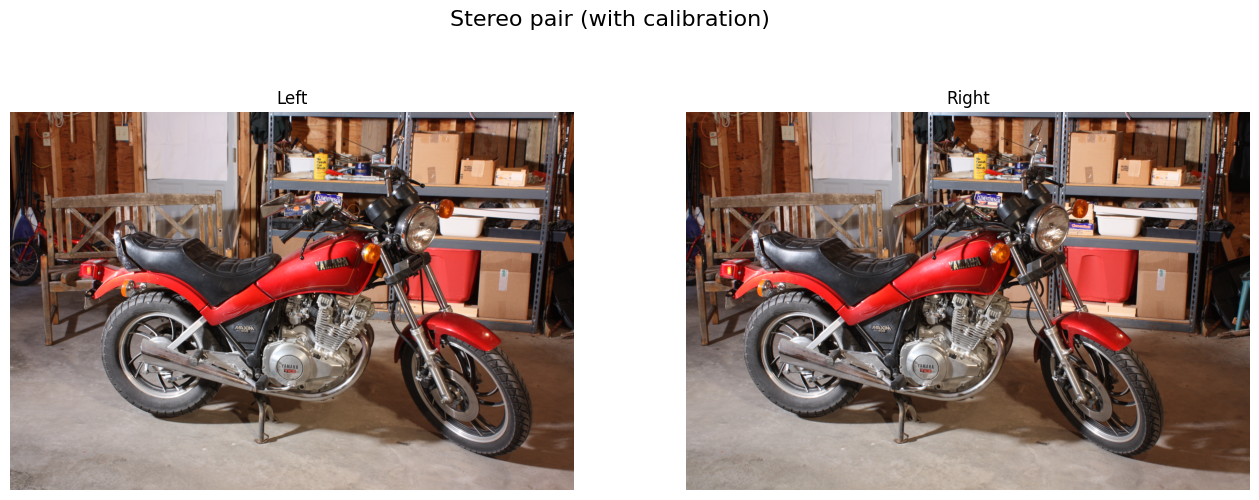

In [28]:
pair_imp.show('Stereo pair (with calibration)')

* Aprēķināt dziļuma karti pēc formulas: 𝑍=(𝑓⋅𝐵)/𝑑
* Vizualizēt rezultātu.

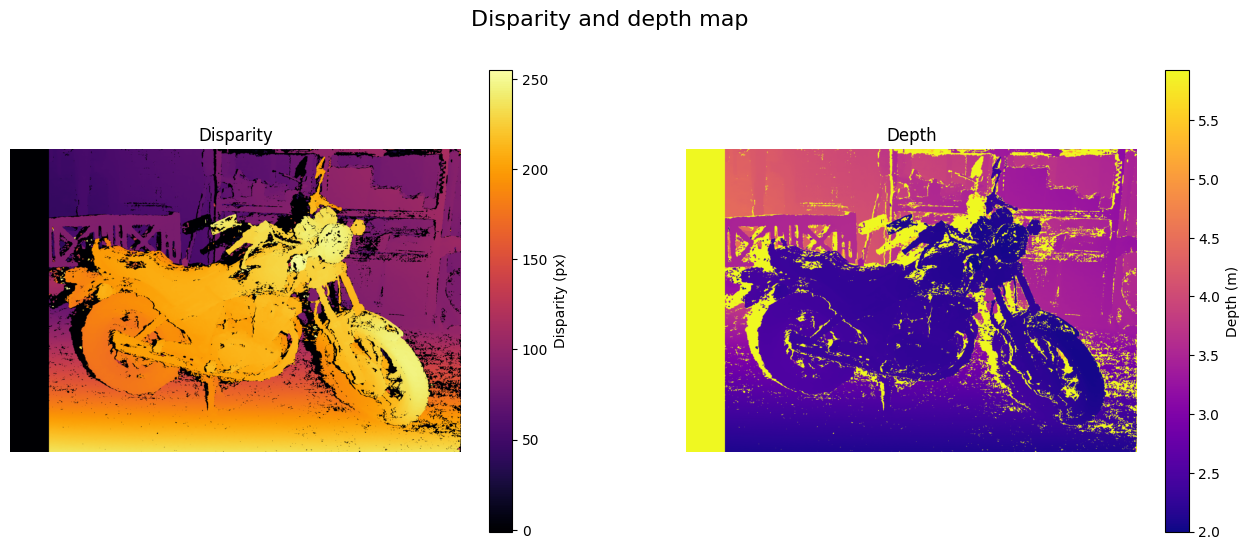

In [29]:
pair_imp.showDisparityAndDepth('Disparity and depth map')

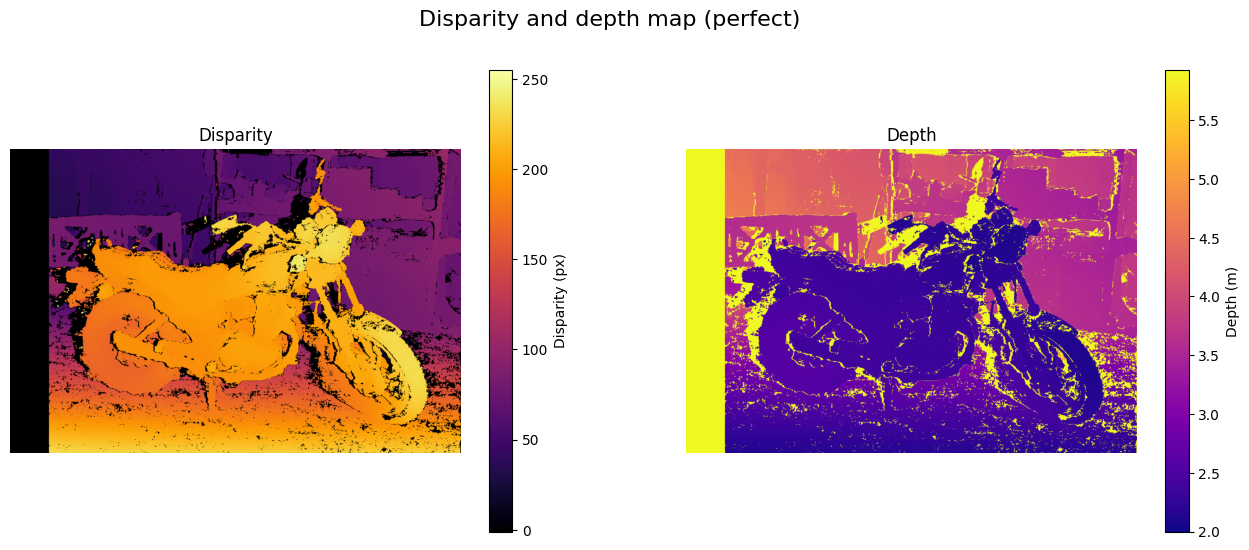

In [30]:
pair_p.showDisparityAndDepth('Disparity and depth map (perfect)')

# Theory

* Kameras kalibrēšana ir process, kas nosaka, kā kamera pārveido 3D
pasauli 2D attēlā.
* Bez kalibrēšanas attēlā:
  - līnijas var izskatīties izliektas (optiskais kropļojums),
  - objektu izmērus un attālumus nevar precīzi noteikt,
  - stereo pāros nevar korekti aprēķināt dziļumu.
* Kalibrēšana ļauj:
  - novērst objektīva kropļojumus,
  - noteikt fokusa garumu un galveno punktu,
  - aprēķināt reālos mērogus un attālumus no attēla,
  - sagatavot kameru stereo redzei un 3D rekonstrukcijai.

Kalibrēšanas rezultāts ir divu tipu parametri:
 - Iekšējie (intrinsic), raksturo pašas
kameras optiku un sensoru.
    - fokusa garumi (pikseļos)
    - attēla centrs
    - kropļojuma koeficienti
 - Ārējie (extrinsic), raksturo kameras
pozīciju un orientāciju telpā.
    - 𝑅: rotācijas matrica
    - 𝑡: translācijas vektors

Reālām lēcām ir:
 - Radiālais kropļojums: 𝑘1 , 𝑘2 , 𝑘3
 - Tangenciālais kropļojums: 𝑝1 , 𝑝2
 - Modelis: 𝑥𝑑𝑖𝑠𝑡 = 𝑥 (1 + 𝑘1 𝑟^2 + 𝑘2 𝑟^4 + 𝑘3 𝑟^6) + 2𝑝1 𝑥𝑦
+ 𝑝2 (𝑟^2 + 2𝑥^2)
 - Kalibrācija ļauj šos koeficientus noteikt un attēlus
izlīdzināt (undistort).

Kalibrēšanas praktiskie ieguvumi
- Pareizs ģeometriskais attēls
Noņem izliektas malas, padara taisnas līnijas taisnas.
- Reālistisks dziļuma aprēķins
Disparitātes aprēķins kļūst precīzs, ja zināms fokusa garums un bāzes
attālums.
- Mērījumu uzticamība
Var noteikt attālumus, izmērus, laukumus milimetros vai metros.
- Labāka stereo rektifikācija
Attēli tiek izlīdzināti, lai atbilstības būtu vienā rindā.
- Neironu tīklu ievade
Precīzāki dati ļauj labāk mācīt modeļus (piemēram, dziļuma kartes vai 3D
segmentāciju).

Kalibrācija apraksta kameras īpašības, nevis konkrētu attālumu
- Kameras iekšējie parametri (intrinsics):
  - fokusa garums 𝑓𝑥 , 𝑓𝑦 ,
  - attēla centrs 𝑐𝑥 , 𝑐𝑦 ,
- kropļojuma koeficienti (𝑘1 , 𝑘2 , 𝑝1 , 𝑝2 ) ir nemainīgi, kamēr:
  - tu nemaini fokusa attālumu (zoom),
  - tu nepārvietojies uz citu fokusa režīmu (piem., auto → macro),
  - tu neizmaini izšķirtspēju vai sensors nav kustīgs.
- Tātad kalibrāciju vari izmantot visiem attālumiem — tā “izlabo” lēcas
un sensoru ģeometriju.

Kas jāievēro pie kalibrācijas
- Kalibrācijas dati kļūst mazāk precīzi, ja:
  - šablons tika fotografēts tikai ļoti tuvu kamerai, bet objekti pēc tam ir tālu (vai
otrādi);
  - šablons bija tikai vienā leņķī, bet lietojumā objekti ir citos skatījumos;
  - objektīvs ir ar mainīgu fokusa garumu (zoom) un tas mainās starp
uzņemšanām;
  - kamera ir mobilā ierīce ar maināmu autofokusu — fokusa garums var
mainīties automātiski.

**Ieteikumi
precīzai
kalibrēšanai**
- Fotografē šaha dēli dažādos attālumos un
leņķos, lai modelis būtu stabils.
- Ja paredzēts darbs aptuveni vienā diapazonā
(piem., 0.5–2 m), tad kalibrē arī apmēram šajā
diapazonā.
- Ja maini zoom vai fokusa režīmu – jākalibrē
no jauna.
- Ja strādā ar viedtālruņiem, centies fiksēt
fokusu (lock focus) pirms attēlu uzņemšanas.

**Tipiskās
kļūdas**
- Neprecīza kalibrācija (maz attēlu, slikts leņķu
sadalījums)
- Attēlu rotācija vai novirze starp kadriem
- Gaismas un ekspozīcijas atšķirības
- Vienmuļas virsmas bez tekstūras
- Pārāk maza bāze (mazs BBB)

Kā atrast fokusa garumu?
(Zhanga metode)
 - Fotografē zināmu šablonu (piem., šaha laukumu)
no dažādiem leņķiem.
 - Atrod stūra punktus katrā attēlā.
 -  Aprēķina projekcijas matricas un iegūst 𝐾, 𝑅, 𝑡.
 -  Optimizē, samazinot projicēšanas kļūdu 𝑒

- Katrs šaha dēļa stūra punkts ir zināms reālajā pasaulē (X, Y, 0).
- Kad mēs šos punktus redzam dažādās attēla pozīcijās, mēs iegūstam
daudzas vienādojumu sistēmas
- Ar vienu attēlu mēs nevaram unikāli noteikt visus parametrus (pārāk
maz datu). Tāpēc:
- uzņemam vairākus attēlus,
- katrs attēls dod jaunus vienādojumus,
- tiek atrisināts kopīgs optimizācijas uzdevums.

Kā tiek atrasts fokusa garums
- Zināmi pasaules punkti (šaha dēļa koordinātas)
- Zināmi to pikseļu koordinātas attēlā
- Nezināmie: 𝑓𝑥 , 𝑓𝑦 , 𝑐𝑥 , 𝑐𝑦 , 𝑘1 , 𝑘2 , . . .
- Zhang metode atrisina optimizācijas problēmu
- Tiek meklētas tādas 𝑓𝑥 , 𝑓𝑦 ,kas vislabāk atbilst visiem attēliem
vienlaikus, samazinot projicēšanas kļūdu starp reālo un aprēķināto
stūri.

# Part two

###3. Disparitātes un dziļuma karte ar reāliem attēliem
* Ar savu viedtālruni uzņemt vismaz 10 foto ar šaha laukuma šablonu (no dažādiem leņķiem un attālumiem).
* Izmantot cv.findChessboardCorners() un cv.calibrateCamera() lai:
noteiktu kameras matricu 𝐾un kropļojuma koeficientus 𝑑𝑖𝑠𝑡,
saglabā rezultātu camera_calib_params.npz.
* Fotografēt divus attēlus (viena aina, bet kamera nobīdīta horizontāli par zināmu bāzi 𝐵, piemēram, 6 cm).
* Izveidot:
  * Disparitātes karti ar StereoSGBM
  * Dziļuma karti, izmantojot 𝑓no kalibrācijas un 𝐵 no mērījuma
* Vizualizēt un kvalitatīvi salīdzināt rezultātus ar Middlebury datiem.


In [31]:
"""
  Kalibrācija – cv.findChessboardCorners, cv.calibrateCamera()
  Attēlu izlīdzināšana (undistort) – cv.undistort()
  Rektifikācija – cv.stereoRectify()

  https://forum.opencv.org/t/asymmetric-circle-grid-calibration/21121/8
  https://longervision.github.io/2017/03/18/ComputerVision/OpenCV/opencv-internal-calibration-circle-grid/
"""

'\n  Kalibrācija – cv.findChessboardCorners, cv.calibrateCamera()\n  Attēlu izlīdzināšana (undistort) – cv.undistort()\n  Rektifikācija – cv.stereoRectify()\n\n  https://forum.opencv.org/t/asymmetric-circle-grid-calibration/21121/8\n  https://longervision.github.io/2017/03/18/ComputerVision/OpenCV/opencv-internal-calibration-circle-grid/\n'

In [32]:
# calibration done in separate notebook

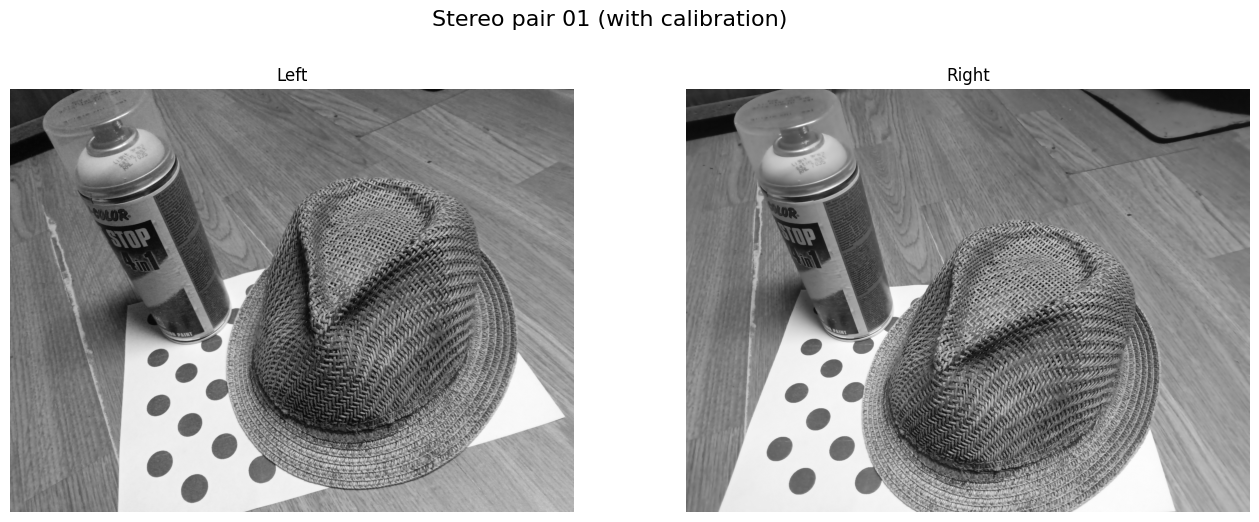

Left image shape: (2448, 3264)
Right image shape: (2448, 3264)
Calibration -> f = 25426.949 px, baseline = 0.100, doffs = 130.000


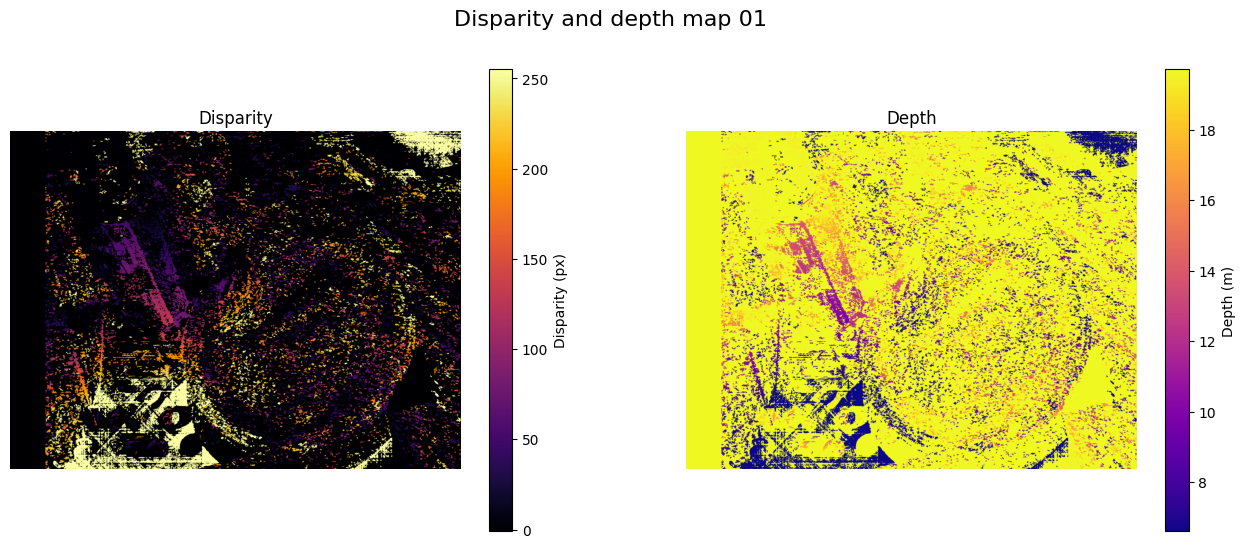

In [41]:
pair_mine01 = Pair(img_mine_path01, withCalib=True)
pair_mine01.show('Stereo pair 01 (with calibration)')
pair_mine01.toString()
pair_mine01.showDisparityAndDepth('Disparity and depth map 01')

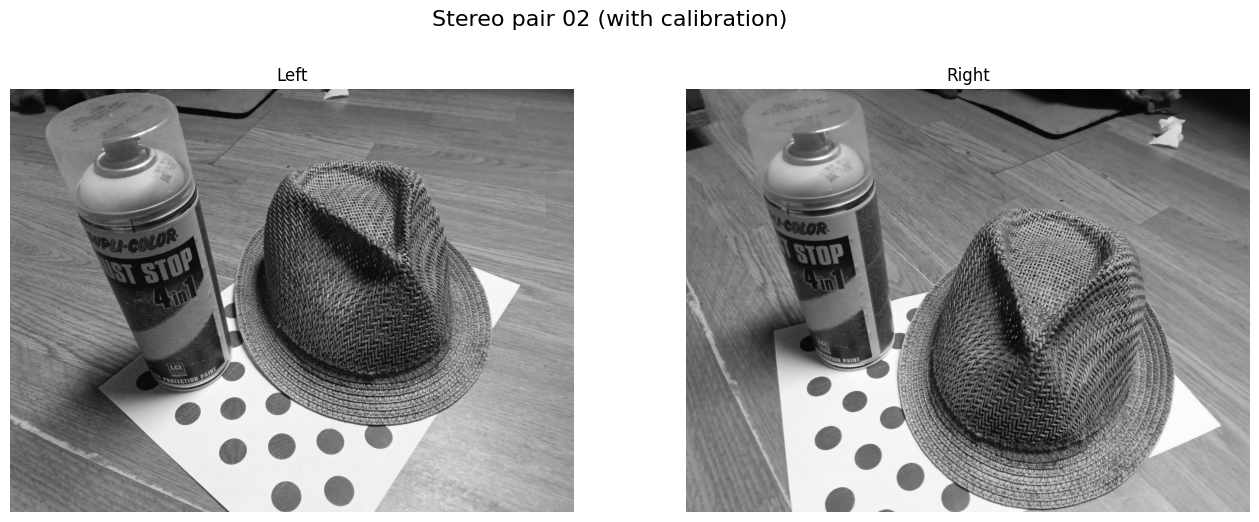

Left image shape: (2448, 3264)
Right image shape: (2448, 3264)
Calibration -> f = 25426.949 px, baseline = 0.200, doffs = -130.000


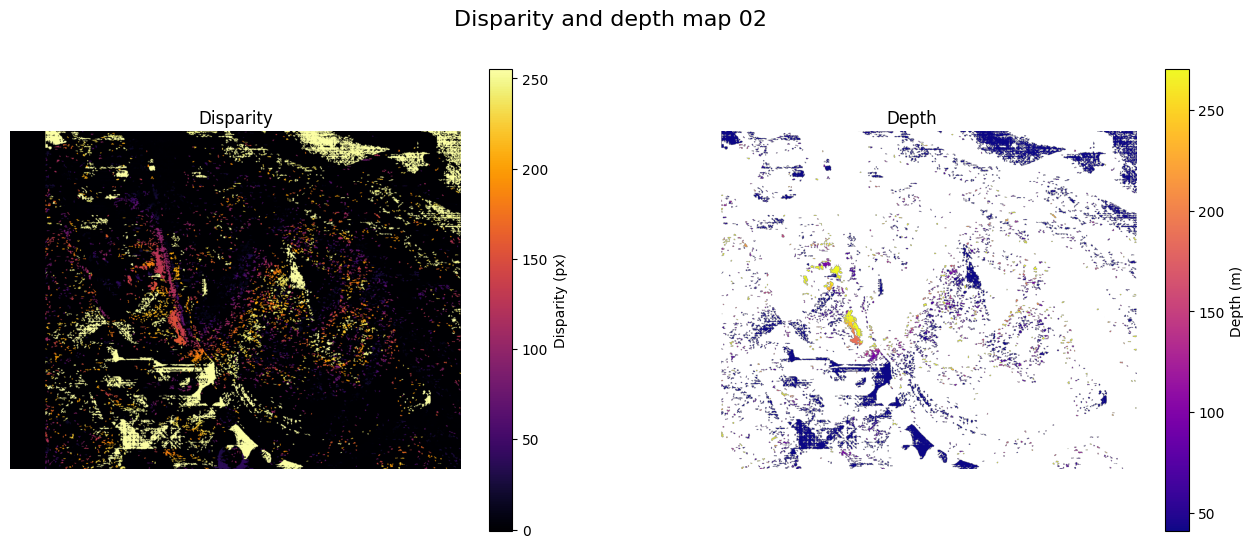

In [44]:
pair_mine02 = Pair(img_mine_path02, withCalib=True)
pair_mine02.show('Stereo pair 02 (with calibration)')
pair_mine02.toString()
pair_mine02.showDisparityAndDepth('Disparity and depth map 02')

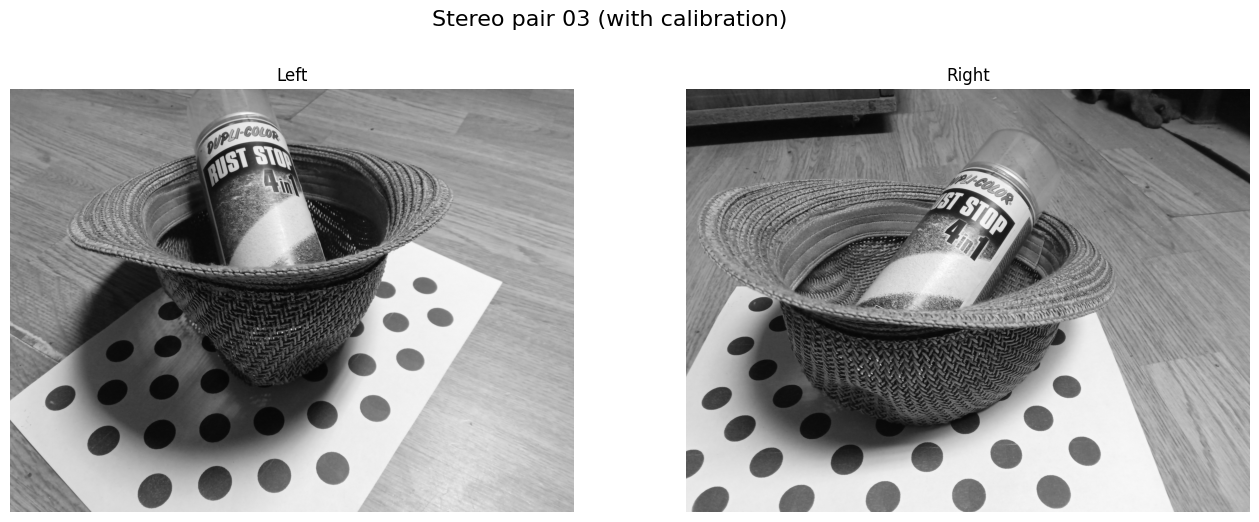

Left image shape: (2448, 3264)
Right image shape: (2448, 3264)
Calibration -> f = 25426.949 px, baseline = 0.400, doffs = 0.000


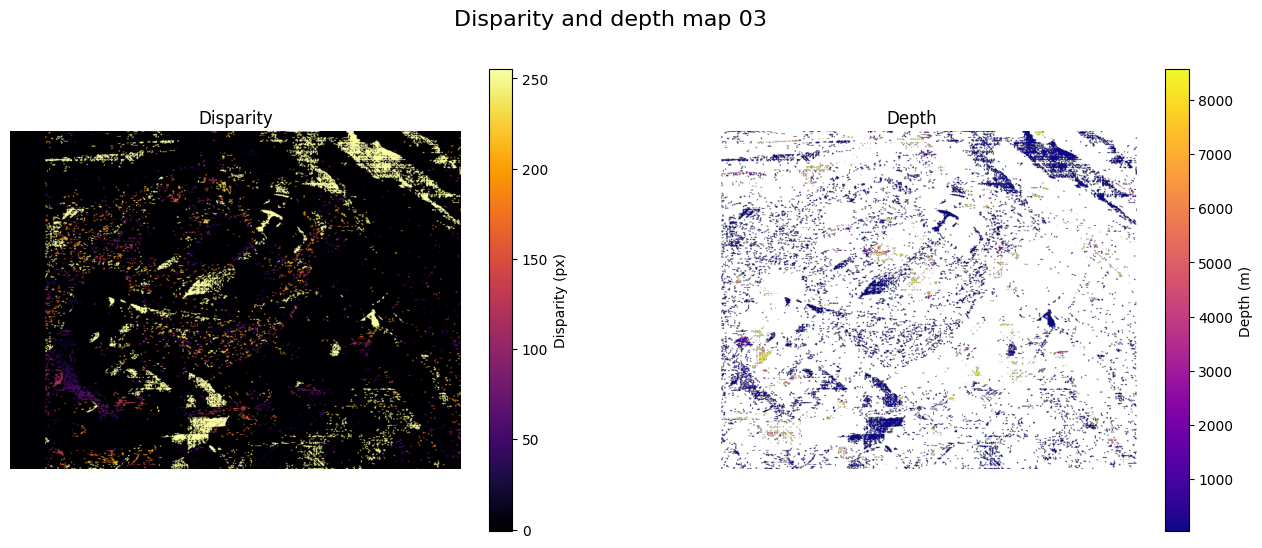

In [57]:
pair_mine03 = Pair(img_mine_path03, withCalib=True)
pair_mine03.show('Stereo pair 03 (with calibration)')
pair_mine03.toString()
pair_mine03.showDisparityAndDepth('Disparity and depth map 03')

### 4. Iesniegšanas kontrolsaraksts
ORTUSā jāiesniedz:
- [ ] Programmas kods (.ipynb)
- [ ] Oriģinālie Middlebury datu kopas attēli (stereo pāris)
- [ ] Disparitātes karte (attēls) bez kalibrācijas
- [ ] Dziļuma karte ar Middlebury kalibrācijas datiem
- [ ] Savi attēli (stereo pāris) un kalibrācijas failu
- [ ] Disparitātes un dziļuma kartes no saviem attēliem
- [ ] Secinājumi (var tikt pievienoti teksta laukā, darba iesniegšanas uzdevumi, vai kā atsēvišķš pdf fails)